In [1]:
# parameters
config_dir = "../experiments"
exp_name = "140_global_avg/all"

In [2]:
%cd /kaggle/working

from pathlib import Path

from hydra import compose, initialize
from omegaconf import OmegaConf

with initialize(
    version_base=None, config_path=f"{config_dir}/{exp_name.split('/')[0]}"
):
    cfg = compose(
        config_name="config.yaml",
        overrides=[f"exp={exp_name.split('/')[-1]}"],
        return_hydra_config=True,
    )
import pickle

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns

# 定数定義
output_dir = Path(f"output/experiments/{exp_name}")
gcs_path = f"gs://{cfg.dir.gcs_bucket}/{cfg.dir.gcs_base_dir}/experiments/{exp_name}/"

# カラムの定義
single_targets = [
    "cam_out_NETSW",
    "cam_out_FLWDS",
    "cam_out_PRECSC",
    "cam_out_PRECC",
    "cam_out_SOLS",
    "cam_out_SOLL",
    "cam_out_SOLSD",
    "cam_out_SOLLD",
]
seq_targets = [
    "ptend_t",
    "ptend_q0001",
    "ptend_q0002",
    "ptend_q0003",
    "ptend_u",
    "ptend_v",
]
target_columns = []
for col in seq_targets:
    for i in range(60):
        target_columns.append(f"{col}_{i}")
target_columns.extend(single_targets)


# 結果などの読み込み
r2_score_dict = pickle.load(open(output_dir / "val2_r2_score_dict.pkl", "rb"))
print("read predict")
predict_df = pl.read_parquet(gcs_path + "val2_predict.parquet", retries=5)
print("read label")
label_df = pl.read_parquet(gcs_path + "val2_label.parquet", retries=5)
ss_df = pl.read_csv(
    "input/leap-atmospheric-physics-ai-climsim/sample_submission.csv", n_rows=1
)
weight_array = ss_df.select([x for x in ss_df.columns if x != "sample_id"]).to_numpy()[
    0
]

/kaggle/working
read predict
read label


## 全体概要

In [3]:
print("r2: ", np.mean(list(r2_score_dict.values())))

r2:  0.785993599455284


## sequential target

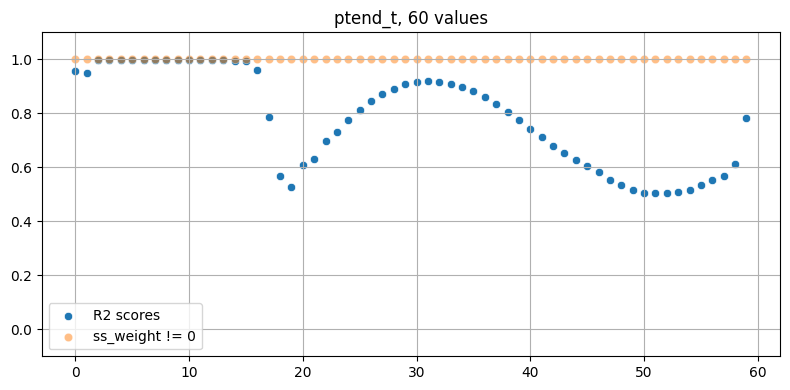

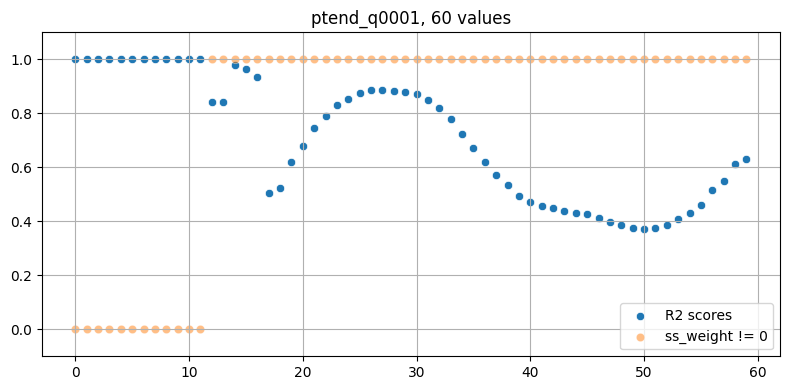

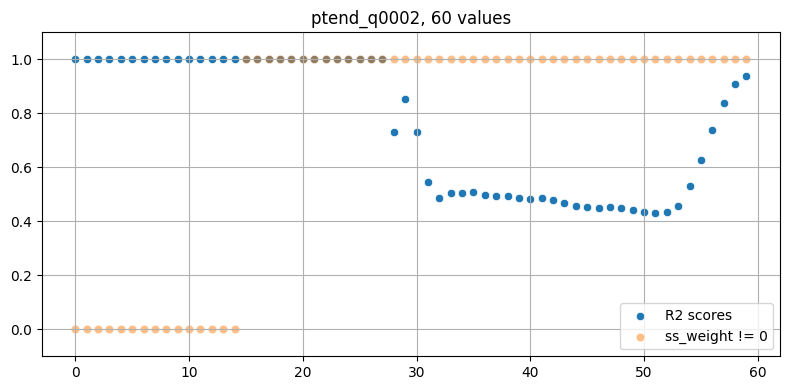

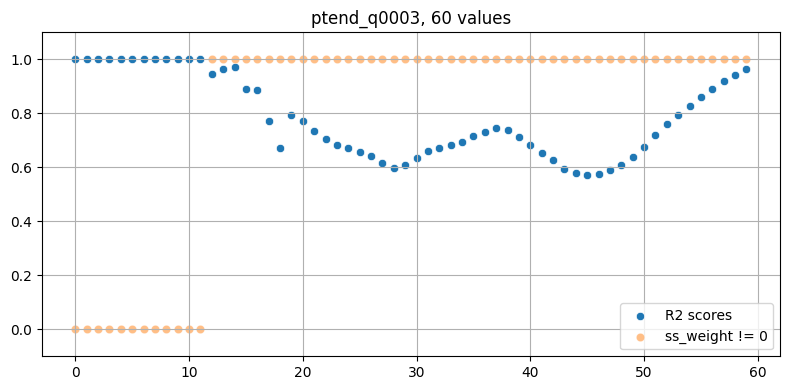

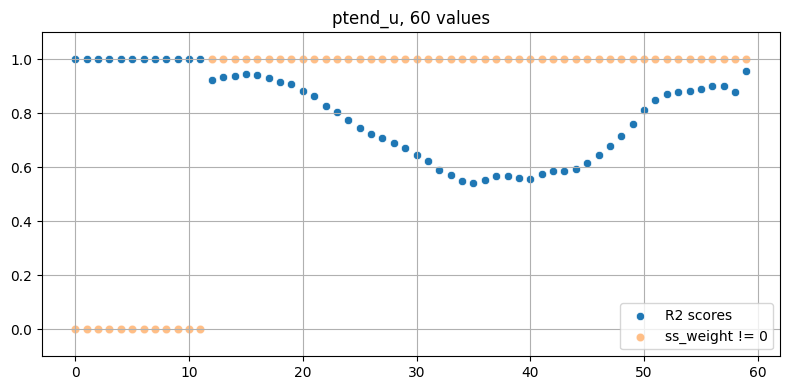

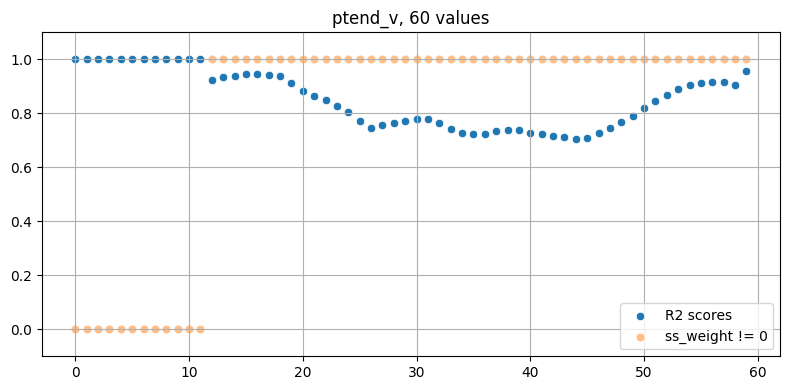

In [4]:
for col in seq_targets:
    fig, ax = plt.subplots(figsize=(8, 4))

    sns.scatterplot(
        x=range(60),
        y=[r2_score_dict[f"{col}_{i}"] for i in range(60)],
        label="R2 scores",
        ax=ax,
    )
    sns.scatterplot(
        x=range(60),
        y=[(ss_df[f"{col}_{i}"].to_numpy()[0] != 0) for i in range(60)],
        alpha=0.5,
        label="ss_weight != 0",
        ax=ax,
    )

    ax.set_title(f"{col}, 60 values")
    ax.grid(True)
    ax.set_ylim(-0.1, 1.1)
    ax.legend()

    plt.tight_layout()
    plt.show()

## single target

cam_out_NETSW : 0.9940755922440655
cam_out_FLWDS : 0.9885447340825806
cam_out_PRECSC : 0.9462568999341863
cam_out_PRECC : 0.9201240035029472
cam_out_SOLS : 0.986745506466841
cam_out_SOLL : 0.9765001437729114
cam_out_SOLSD : 0.9805309165525264
cam_out_SOLLD : 0.9252183701174783


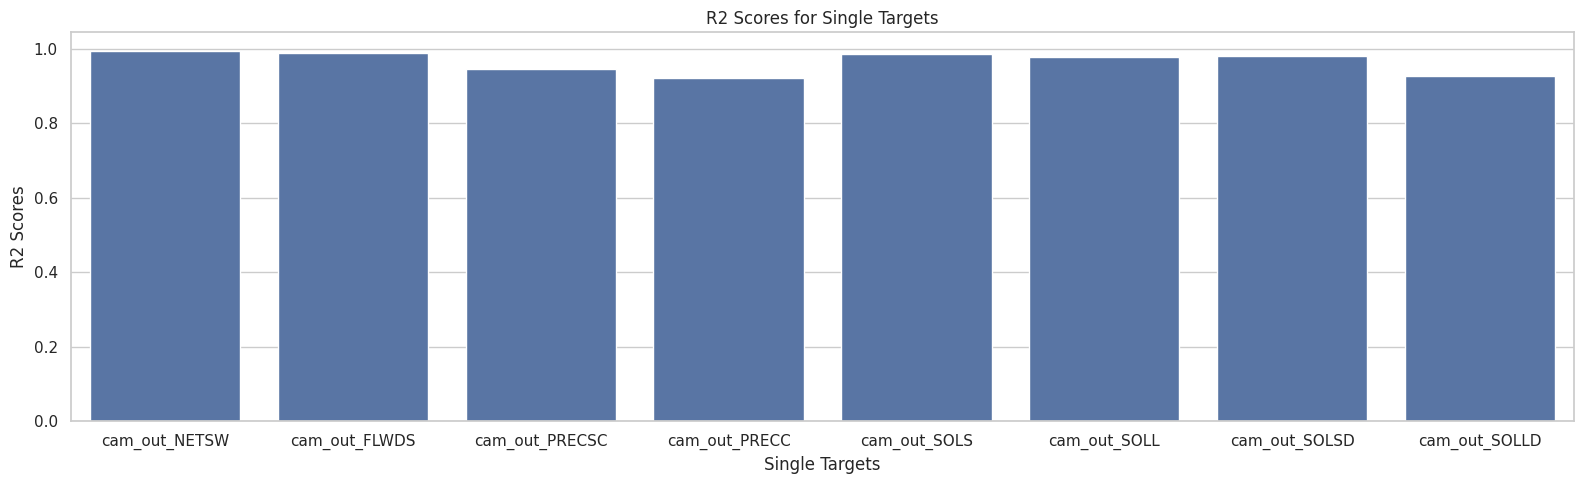

In [5]:
# single scaler target
plt.figure(figsize=(16, 5))
sns.set(style="whitegrid")

sns.barplot(
    x=np.array(single_targets),
    y=np.array([r2_score_dict[col] for col in single_targets]),
)

plt.xlabel("Single Targets")
plt.ylabel("R2 Scores")
plt.title("R2 Scores for Single Targets")

for col in single_targets:
    print(f"{col} : {r2_score_dict[col]}")

plt.tight_layout()
plt.show()

## マイナスが大きいターゲットについて確認

In [6]:
preds = predict_df[:, 1:].to_numpy()
labels = label_df[:, 1:].to_numpy()

scale_dir = ""
y_nanmean = np.load(Path(cfg.exp.scale_dir) / "y_nanmean.npy")
y_rms_sub = np.load(Path(cfg.exp.scale_dir) / "y_rms_sub.npy")
y_lower_bound = np.load(Path(cfg.exp.scale_dir) / "y_nanmin.npy")
y_upper_bound = np.load(Path(cfg.exp.scale_dir) / "y_nanmax.npy")


for ci, col in enumerate(target_columns):
    r2_score = r2_score_dict[col]
    if r2_score > 0.01:
        continue

    print("【", col, "】")
    print(f"{r2_score=:.5g}")

    mse = (preds[:, ci] - labels[:, ci]) ** 2
    base = (labels[:, ci] - labels[:, ci].mean()) ** 2
    ri = np.nonzero(mse == np.max(mse))[0][0]
    print(f"{ri=}, {ci=}")
    print(f"{preds[ri,ci]=:.5g}, {labels[ri,ci]=:.5g}")
    print(f"{mse[ri]=:.5g}, r2: 1-({mse.mean()=:.5g})/({base.mean()=:.5g})")

    print(
        f"{y_rms_sub[ci]=:.5g}, {y_nanmean[ci]=:.5g}, {y_lower_bound[ci]=:.5g}, {y_upper_bound[ci]=:.5g}"
    )
    print(
        f"{preds[:,ci].mean()=:.5g}, {preds[:,ci].min()=:.5g}, {preds[:,ci].max()=:.5g}"
    )
    print(
        f"{labels[:,ci].mean()=:.5g}, {labels[:,ci].min()=:.5g}, {labels[:,ci].max()=:.5g}"
    )
    print()

## 値が大きくないやつ

In [7]:
preds = predict_df[:, 1:].to_numpy()
labels = label_df[:, 1:].to_numpy()

scale_dir = ""
y_nanmean = np.load(Path(cfg.exp.scale_dir) / "y_nanmean.npy")
y_rms_sub = np.load(Path(cfg.exp.scale_dir) / "y_rms_sub.npy")
y_lower_bound = np.load(Path(cfg.exp.scale_dir) / "y_nanmin.npy")
y_upper_bound = np.load(Path(cfg.exp.scale_dir) / "y_nanmax.npy")


for ci, col in enumerate(target_columns):
    r2_score = r2_score_dict[col]
    if r2_score > 0.5:
        continue

    print("【", col, "】")
    print(f"{r2_score=:.5g}")

    mse = (preds[:, ci] - labels[:, ci]) ** 2
    base = (labels[:, ci] - labels[:, ci].mean()) ** 2
    ri = np.nonzero(mse == np.max(mse))[0][0]
    print(f"{ri=}, {ci=}")
    print(f"{preds[ri,ci]=:.5g}, {labels[ri,ci]=:.5g}")
    print(f"{mse[ri]=:.5g}, r2: 1-({mse.mean()=:.5g})/({base.mean()=:.5g})")

    print(
        f"{y_rms_sub[ci]=:.5g}, {y_nanmean[ci]=:.5g}, {y_lower_bound[ci]=:.5g}, {y_upper_bound[ci]=:.5g}"
    )
    print(
        f"{preds[:,ci].mean()=:.5g}, {preds[:,ci].min()=:.5g}, {preds[:,ci].max()=:.5g}"
    )
    print(
        f"{labels[:,ci].mean()=:.5g}, {labels[:,ci].min()=:.5g}, {labels[:,ci].max()=:.5g}"
    )
    print()

【 ptend_q0001_39 】
r2_score=0.49476
ri=30892, ci=99
preds[ri,ci]=5.3216e-08, labels[ri,ci]=5.7321e-07
mse[ri]=2.7039e-13, r2: 1-(mse.mean()=5.3517e-16)/(base.mean()=1.0593e-15)
y_rms_sub[ci]=3.3479e-08, y_nanmean[ci]=-1.9747e-09, y_lower_bound[ci]=-9.9134e-07, y_upper_bound[ci]=1.0146e-06
preds[:,ci].mean()=-1.9777e-09, preds[:,ci].min()=-5.482e-07, preds[:,ci].max()=6.9386e-07
labels[:,ci].mean()=-2.0198e-09, labels[:,ci].min()=-6.3393e-07, labels[:,ci].max()=7.9058e-07

【 ptend_q0001_40 】
r2_score=0.47238
ri=405250, ci=100
preds[ri,ci]=-1.2478e-07, labels[ri,ci]=3.8574e-07
mse[ri]=2.6063e-13, r2: 1-(mse.mean()=6.8603e-16)/(base.mean()=1.3002e-15)
y_rms_sub[ci]=3.7061e-08, y_nanmean[ci]=-1.7037e-09, y_lower_bound[ci]=-9.3931e-07, y_upper_bound[ci]=9.5089e-07
preds[:,ci].mean()=-1.6413e-09, preds[:,ci].min()=-5.6404e-07, preds[:,ci].max()=6.4973e-07
labels[:,ci].mean()=-1.7774e-09, labels[:,ci].min()=-7.5642e-07, labels[:,ci].max()=6.7933e-07

【 ptend_q0001_41 】
r2_score=0.45848
ri=143